In [169]:
import pandas as pd
import numpy as np
import os
from time import time

%matplotlib inline
import matplotlib.pyplot as plt # to show images
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import pandas as pd
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # for PCA calculation
from sklearn import manifold, datasets
import cv2
from collections import OrderedDict
from functools import partial
# Next line to silence pyflakes. This import is needed.
Axes3D
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
class_labels=['COVID','Normal','Lung_Opacity','Viral Pneumonia']
pic=cv2.imread('../Data/COVID-19_Radiography_Dataset_256x256/{class_label}/{class_label}-{n}.png'.format(class_label=class_labels[2],n=1))

In [3]:
pic=cv2.imread('../Data/COVID-19_Radiography_Dataset_256x256/Lung/{class_label}-{n}.png')

In [4]:
'../Data/COVID-19_Radiography_Dataset_256x256/{class_label}/{class_label}-{n}.png'.format(class_label=class_labels[2],n=1)

'./COVID-19_Radiography_Dataset_256x256/Lung_Opacity/Lung_Opacity-1.png'

In [170]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def std_scaler(X):
    scaler = StandardScaler().fit(X)
    return scaler.transform(X)

In [227]:
class_dic={'COVID':1,'Normal':2,'Lung':3,'Viral':4,'GAN-COVID':5,'GAN-Normal':6,'GAN-Lung':7,'GAN-Viral':8}
marker_dic={'COVID':'o','Normal':'o','Lung':'o','Viral':'o','GAN-COVID':'>','GAN-Normal':'>','GAN-Lung':'>','GAN-Viral':'>'}
color_dic={'COVID':6,'Normal':0,'Lung':2,'Viral':1,'GAN-COVID':6,'GAN-Normal':0,'GAN-Lung':2,'GAN-Viral':1}
def load_data(n_data,resolution=256,class_labels=['COVID','Normal'],file_labels=['COVID','Normal'],path='./COVID-19_Radiography_Dataset_256x256/'):
    class_labels=['COVID','Normal','Lung','Viral']
    file_labels=['COVID','Normal','Lung_Opacity','Viral Pneumonia']
    
    #class_labels=['COVID','Normal']
    filename='{class_labels}/{file_labels}-{n}.png'
    X=[]
    y=[]
    for i in range(len(class_labels)):
        #n=1
        for j in range(n_data):
            im=cv2.imread(path+filename.format(file_labels=file_labels[i],class_labels=class_labels[i],n=j+1),cv2.IMREAD_UNCHANGED)
            '''
            if im.shape !=(299,299):
                #skip the three-channel picture
                j=j-1
                n=n+1
                continue
            n+=1
            '''
            x=np.reshape(cv2.resize(im,(resolution,resolution)),[resolution**2])
            X.append(x)
            y.append(i+1)
    X=np.asarray(X)
    y=np.asarray(y)
    return np.asarray(X),np.asarray(y)

def load_generated_data_plus(n_data):
    path_generated='./Generated_Images/StyleGAN2-ada/1class-COVID-002600_0-511/seed%04d.png'
    X = []
    for i in range(n_data):
        im=cv2.imread(path_generated%(i),cv2.IMREAD_UNCHANGED)
        x=np.reshape(im,[im.shape[0]*im.shape[1]])
        X.append(x)
    y =[0]*n_data
    return np.asarray(X),np.asarray(y)

def load_generated_data(n_data,class_labels=['COVID','Normal','Lung','Viral']):
    #path_generated='./Generated_Images/StyleGAN2-ada/2classes-cond-%s-003830_0-511/seed%04d.png'
    path_generated='./Synthesis4Viz/4cGAN-%s-1000/seed%04d.png'
    X=[]
    y=[]
    for i,item in enumerate(class_labels):
        for j in range(n_data):
            im=cv2.imread(path_generated%(item,j),cv2.IMREAD_UNCHANGED)
            x=np.reshape(im,[im.shape[0]*im.shape[1]])
            X.append(x)
            y.append(i+5)
    return np.asarray(X),np.asarray(y)


def plot_data(x,y,plot_number=100,class_labels=['COVID','Normal'],s=2):
    plt.figure(figsize=(8,8))
    #class_labels=['COVID','Lung_Opacity','Normal','Viral Pneumonia']
    for k in class_labels:
        print(k)
        x_axis_data = x[y==class_dic[k],0]
        y_axis_data = x[y==class_dic[k],1]       
        plt.scatter(x_axis_data[:plot_number], y_axis_data[:plot_number],marker=marker_dic[k],color=colors[color_dic[k]],s=s,label=k)
    plt.title("Covid X-Ray Dataset (Dimensionality Reduced With PCA)")
    plt.legend()
    
def plot_data_3d(x,y,class_labels=['COVID','Normal']):
    #class_labels=['COVID','Lung_Opacity','Normal','Viral Pneumonia']
    px = 1/plt.rcParams['figure.dpi']
    fig = plt.figure(figsize=(800*px, 800*px))
    ax = fig.add_subplot(projection='3d')
    for k in class_labels:
        x_axis_data = x[y==class_dic[k],0]
        y_axis_data = x[y==class_dic[k],1]
        z_axis_data = x[y==class_dic[k],2]
        ax.scatter(x_axis_data, y_axis_data,z_axis_data,s=2,marker=marker_dic[k],color=colors[color_dic[k]],label=k)
    #ax.view_init(30,30)
    plt.xlim(-0.8,0.8)
    plt.ylim(-0.8,0.8)
    plt.title("Covid X-Ray Dataset (Dimensionality Reduced With PCA)")
    plt.legend()

In [217]:
def get_keys(d, value):
     return [k for k,v in d.items() if v == value]
    
def _pca(X,y,plot_number=100,plot2d=True,plot3d=False,s=2):
    X_std=std_scaler(X)
    pca=PCA(n_components=3).fit(X_std)
    X_trans=pca.transform(X_std)
    print("explained_variance_ratio: ")
    print(pca.explained_variance_ratio_)
    minmax_scale = MinMaxScaler((-1, 1)).fit(X_trans)
    X_final = minmax_scale.transform(X_trans)
    class_index=list(set(y))
    class_names=[get_keys(class_dic,i)[0] for i in class_index]
    print(class_names)
    if plot2d==True:
        plot_data(X_final,y,plot_number=plot_number,marker=marker_dic[k],color=colors[color_dic[k]],class_labels=class_names,s=s)
    if plot3d==True:
        plot_data_3d(X_final,y,class_names)
    return X_final,y

In [218]:
##method dic for manifold learing
n_neighbors = 10
n_components = 2

LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')
methods = OrderedDict()
methods['LLE'] = LLE(method='standard')

#methods['LTSA'] = LLE(method='ltsa')
#methods['Hessian LLE'] = LLE(method='hessian')
#methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

def _manifold(X,y,methods,plot_number=100,s=2):
    X=std_scaler(X)
    fig, axs = plt.subplots(2, 3,figsize=(15, 8))
    class_index=list(set(y))
    class_names=[get_keys(class_dic,i)[0] for i in class_index]
    fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (len(y), n_neighbors ), fontsize=14)
    for i, (label, method) in enumerate(methods.items()):
        t0 = time()
        Y = method.fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (label, t1 - t0))
        for k in class_names:
            x_axis_data = Y[y==class_dic[k],0]
            y_axis_data = Y[y==class_dic[k],1]
            axs[i//3,i%3].scatter(x_axis_data[:plot_number], y_axis_data[:plot_number],marker=marker_dic[k],color=colors[color_dic[k]],s=s,label=k)
        axs[i//3,i%3].set_title("%s (%.2g sec)" % (label, t1 - t0))
        axs[i//3,i%3].xaxis.set_major_formatter(NullFormatter())
        axs[i//3,i%3].yaxis.set_major_formatter(NullFormatter())
        #axs[i//3,i%3].legend(loc='best')
        axs[i//3,i%3].axis('tight')
    axs[-1,-1].axis('off')
    handles, labels = axs[-1,-2].get_legend_handles_labels()
    axs[-1,-1].legend(handles, labels, fontsize=16,loc='upper center')
    plt.show()

/home/zwubp/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [219]:
def all_together(X,y,methods,suffix,plot_number=100,s=2):
    fig, axs = plt.subplots(2, 3,figsize=(16, 8))
    class_index=list(set(y))
    class_names=[get_keys(class_dic,i)[0] for i in class_index]
    fig.suptitle("PCA and Manifold Learning", fontsize=14)
    #axs[0,0].axis('off')
    #axs[-1,-1].axis('off')
    X_std=std_scaler(X)
    t0 = time()
    pca=PCA(n_components=3).fit(X_std)
    t1 = time()
    X_trans=pca.transform(X_std)
    minmax_scale = MinMaxScaler((-1, 1)).fit(X_trans)
    x = minmax_scale.transform(X_trans)
    for k in class_names:
        x_axis_data = x[y==class_dic[k],0]
        y_axis_data = x[y==class_dic[k],1]       
        axs[0,0].scatter(x_axis_data[:plot_number], y_axis_data[:plot_number],marker=marker_dic[k],color=colors[color_dic[k]],s=s,label=k)
    axs[0,0].set_title("%s (%.2g sec)" % ('PCA', t1 - t0))
    axs[0,0].xaxis.set_major_formatter(NullFormatter())
    axs[0,0].yaxis.set_major_formatter(NullFormatter())
    axs[0,0].axis('tight')
    
    for i, (label, method) in enumerate(methods.items()):
        t0 = time()
        Y = method.fit_transform(X_std)
        t1 = time()
        print("%s: %.2g sec" % (label, t1 - t0))
        for k in class_names:
            x_axis_data = Y[y==class_dic[k],0]
            y_axis_data = Y[y==class_dic[k],1]
            axs[(i+1)//3,(i+1)%3].scatter(x_axis_data[:plot_number], y_axis_data[:plot_number],marker=marker_dic[k],color=colors[color_dic[k]],s=s,label=k)
        axs[(i+1)//3,(i+1)%3].set_title("%s (%.2g sec)" % (label, t1 - t0))
        axs[(i+1)//3,(i+1)%3].xaxis.set_major_formatter(NullFormatter())
        axs[(i+1)//3,(i+1)%3].yaxis.set_major_formatter(NullFormatter())
        #axs[i//3,i%3].legend(loc='best')
        axs[(i+1)//3,(i+1)%3].axis('tight')
    handles, labels = axs[-1,-1].get_legend_handles_labels()
    #axs[0,0].legend(handles, labels, fontsize=16,loc='upper center')
    lgnd=fig.legend(labels, loc='center left',markerscale=3,fontsize=12)
    #name=['original','with_GAN']
    filename='./fig/data_reduction_%s.eps'%(suffix)
    plt.savefig(filename,format='eps')

# Dimension reduction for original data. 

In [230]:
X,y=load_data(1000)

LLE: 16 sec
Isomap: 9.4 sec
MDS: 41 sec
SE: 3.4 sec
t-SNE: 14 sec


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


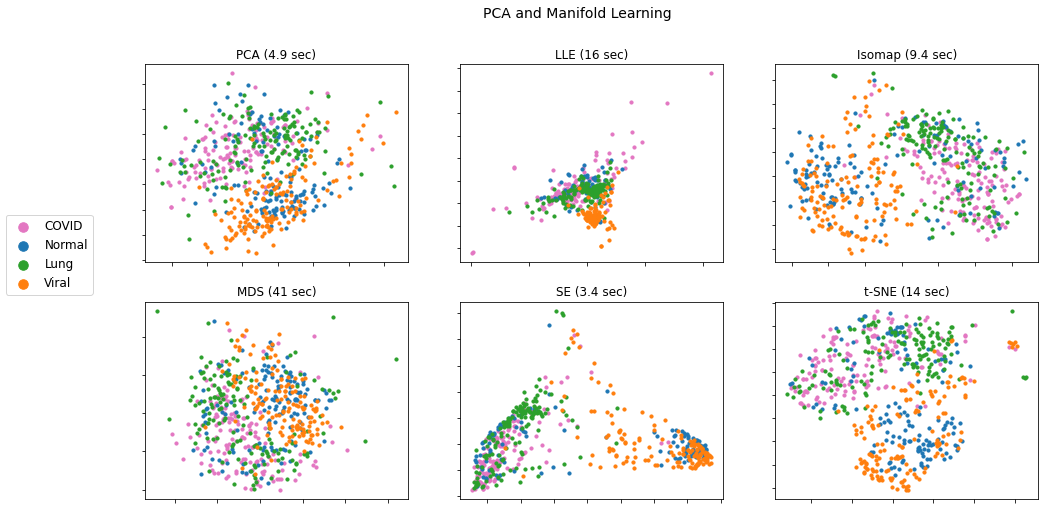

In [231]:
all_together(X,y,methods,'original',plot_number=150,s=10)

In [ ]:
## several lle method removed due to singularity in matrix inverse

# Dimension reduction for original and conditional GAN data. 

In [232]:
X_o,y_o=load_data(1000)
X_g,y_g=load_generated_data(500)
X=np.append(X_o, X_g, axis=0)
y=np.append(y_o, y_g,axis=0)

LLE: 37 sec
Isomap: 22 sec
MDS: 88 sec
SE: 8.9 sec
t-SNE: 22 sec


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


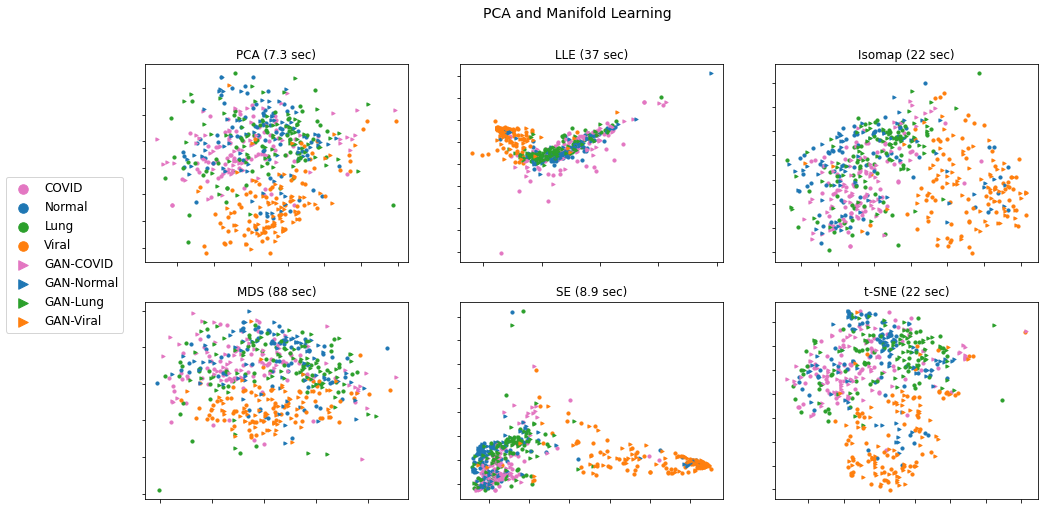

In [233]:
all_together(X,y,methods,'with_GAN',plot_number=70,s=10)

# Dimension reduction for GAN data

LLE: 22 sec
Isomap: 10 sec
MDS: 40 sec
SE: 4.4 sec
t-SNE: 14 sec


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


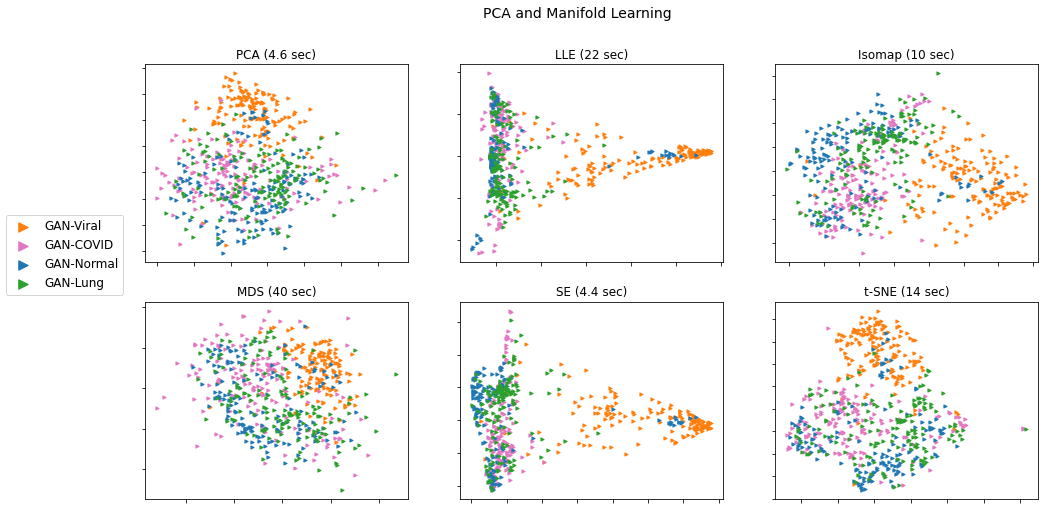

In [235]:
all_together(X,y,methods,'allGAN',plot_number=150,s=10)